In [1]:
import pandas as pd
import numpy as np
import yaml
import sys
import torch
from torch.utils.data import DataLoader
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('/home/lugeon/eeg_project/scripts')
sys.path.append('/mlodata1/lugeon/eeg_dream/scripts')

from training.dataset import datasets
from training.representation import models

sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
device = torch.device('cuda:0')
model_dir = '/mlodata1/lugeon/eeg_dream/results/masking_ratio/autoencoder_mask95'


with open(f'{model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

# get model from model name
model_function = getattr(models, config['model']['name'])
model = model_function(**config['model']['kwargs'])

model.load_state_dict(torch.load(f'{model_dir}/checkpoint.pt'))

if isinstance(model, models.AdverserialAutoencoder):
    model = model.model

#model.masking_ratio = 0

model.to(device)
model.eval();

In [17]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_nrem_binary/dataset_256e.h5'

dataset = datasets.EEG_Image_Batch_Dataset(hdf5_file, 
                                           window=10, 
                                           slide=5, 
                                           batch_size=128, 
                                           shuffle=False, 
                                           return_metadata=False,
                                           exclude_subject=[],
                                           output_type='none')

with h5py.File(dataset.hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
dataset

In [24]:
loader = DataLoader(dataset, batch_size=None, shuffle=False)

shuffle_idx = []
inputs = []
outputs = []

with torch.no_grad():
    for input_batch, output_batch in tqdm(loader, ncols=70):
                                    
        # send to device
        input_batch = input_batch.to(device) 
        
        encoding, shuffling_idx = model.encode(input_batch, return_idx=True)
        reconstruction, mask = model.decode(encoding, shuffling_idx)
        
        batch_size = input_batch.size(0)

        offset = (torch.arange(batch_size) * model.n_patches) \
                    .unsqueeze(1).repeat(1, model.n_patches)
        shuffling_idx = shuffling_idx.reshape(batch_size, -1) - offset
        
        shuffle_idx.append(shuffling_idx.cpu().detach().numpy())
        inputs.append(input_batch.cpu().detach().numpy())
        outputs.append(reconstruction.cpu().detach().numpy())
        
        del input_batch
        del output_batch
        
        
shuffle_idx = np.concatenate(shuffle_idx)
inputs = np.concatenate(inputs)
outputs = np.concatenate(outputs)

100%|█████████████████████████████████| 18/18 [00:02<00:00,  8.18it/s]


In [25]:
n_masked = int(model.n_patches * model.masking_ratio)
keep = model.n_patches - n_masked

visible_patch = np.zeros_like(shuffle_idx)
for i in range(shuffle_idx.shape[0]):
    kept = shuffle_idx[i][:keep]
    visible_patch[i][kept] = 1
    
single_space_dim = int(model.space_n_patches**(1/2))
visible_patch = visible_patch.reshape(-1, model.time_n_patches, 
                          single_space_dim, single_space_dim)

In [26]:
# TODO: make this pythonic and efficient
visible_pixel = np.zeros_like(inputs).astype(bool)
for b in range(visible_pixel.shape[0]):
    for t in range(visible_pixel.shape[1]):
        for x in range(visible_pixel.shape[3]):
            for y in range(visible_pixel.shape[4]):
                
                patch = visible_patch[
                    b,
                    t // model.time_patch_size,
                    x // model.space_patch_size,
                    y // model.space_patch_size
                ]
                
                visible_pixel[b, t, :, x, y] = bool(patch)

In [27]:
masked = np.zeros_like(inputs)
masked[visible_pixel] = inputs[visible_pixel]

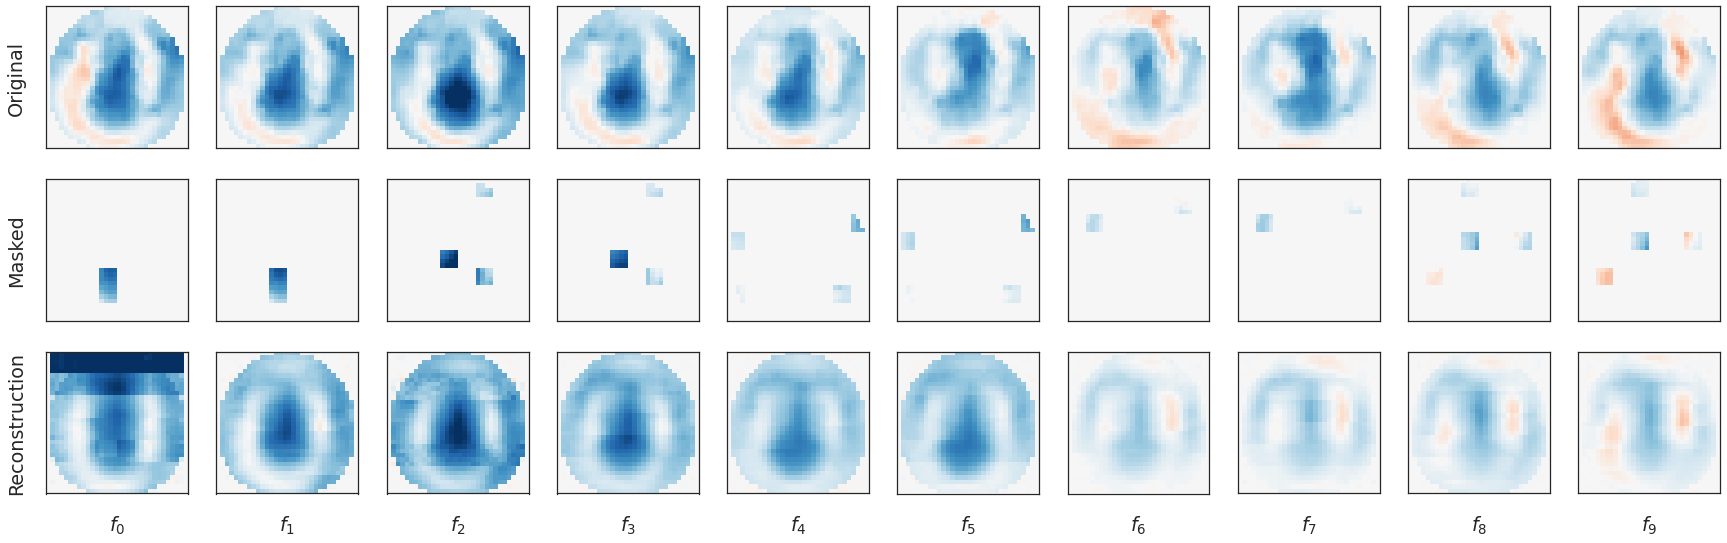

In [30]:
sample = 2
freq_band = 3
t_start = 0

fig, ax = plt.subplots(3, 10, figsize=(30, 9))

for t in range(10):
    ax[0, t].imshow(inputs[sample, t_start + t, freq_band, :, :], cmap='RdBu', vmin=-2, vmax=2);
    ax[1, t].imshow(masked[sample, t_start + t, freq_band, :, :], cmap='RdBu', vmin=-2, vmax=2);
    ax[2, t].imshow(outputs[sample, t_start + t, freq_band, :, :], cmap='RdBu', vmin=-2, vmax=2);
    
    for i in [0, 1, 2]:
        ax[i, t].set_xticks([])
        ax[i, t].set_yticks([])
        
    if t == 0:
        ax[0, t].set_ylabel('Original', labelpad=20)
        ax[1, t].set_ylabel('Masked', labelpad=20)
        ax[2, t].set_ylabel('Reconstruction', labelpad=20)
        
    ax[2, t].set_xlabel(f'$f_{t}$', labelpad=20)

plt.savefig('img/reconstruction_95.pdf', bbox_inches='tight')
plt.show()
